## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
import copy
from sklearn.feature_extraction import FeatureHasher
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

## File System

In [4]:
DATA_DIR =  "/Users/jackgraham/misc/handson-ml2/datasets/unsw/"
testing_fname = "UNSW_NB15_testing-set.csv"
training_fname = "UNSW_NB15_training-set.csv"

## Reading and Feature Labeling

In [5]:
df1 = pd.read_csv(DATA_DIR + training_fname)
df2 =  pd.read_csv(DATA_DIR  + testing_fname)
df = df1.append(df2)


label_feature = ['attack_cat']
categorical_features = ['proto', 'service', 'state']
drop_features = ['id', 'sttl', 'dttl', 'swin', 'dwin', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'label']
numerical_features = list(set(df.columns) - set(label_feature) - set(categorical_features) - set(drop_features))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1424eaf10>]],
      dtype=object)

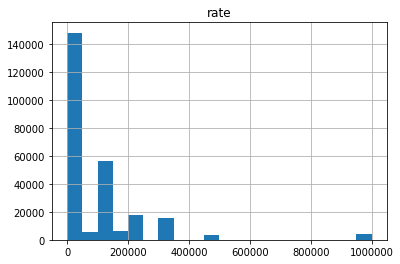

In [6]:
df.hist(column='rate',bins=20)

### Normalize

In [7]:
float_array = df[['rate']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
scaled_array = min_max_scaler.fit_transform(float_array)
df_normalized = pd.DataFrame(scaled_array)
df_normalized.head()

,0
0,0.000074
1,0.000078
2,0.000014
3,0.000014
4,0.000033


In [8]:
scaler = preprocessing.MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [9]:
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.002025,tcp,-,FIN,0.000470,0.000363,0.000016,0.000012,0.000074,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.010832,tcp,-,FIN,0.001221,0.003449,0.000049,0.002866,0.000078,...,1,2,0,0,0,1,6,0,Normal,0
2,3,0.027052,tcp,-,FIN,0.000658,0.001452,0.000024,0.000900,0.000014,...,1,3,0,0,0,2,6,0,Normal,0
3,4,0.028027,tcp,ftp,FIN,0.001033,0.001089,0.000042,0.000053,0.000014,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.007491,tcp,-,FIN,0.000845,0.000545,0.000036,0.000018,0.000033,...,1,40,0,0,0,2,39,0,Normal,0


In [10]:
len(df['attack_cat'].unique())
type(df['attack_cat'])

pandas.core.series.Series

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x142ce55d0>]],
      dtype=object)

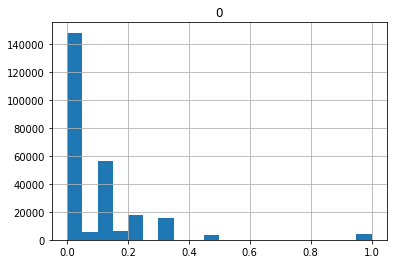

In [11]:
df_normalized.hist(column=0,bins=20)

## Train, Validation, Test Split

In [12]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

164910 train examples
41228 validation examples
51535 test examples


In [13]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    # Transform name species into numerical values 
    encoder = preprocessing.LabelEncoder()
    encoder.fit(dataframe['attack_cat'])
    dataframe['attack_cat'] = encoder.transform(dataframe['attack_cat'])
    dataframe['attack_cat'] = tf.keras.utils.to_categorical(dataframe['attack_cat'])

    dataframe = dataframe.copy()
    labels = dataframe.pop('attack_cat')
    dataframe = dataframe.drop(drop_features, axis=1)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [14]:
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val, shuffle=False)
test_ds = df_to_dataset(test, shuffle=False)

/Users/jackgraham/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jackgraham/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [15]:
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of labels:', label_batch )

Every feature: ['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'stcpb', 'dtcpb', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean']
A batch of labels: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.], shape=(32,), dtype=float32)


In [16]:
a = train_ds.take(10)

### Making Feature Columns

In [17]:
# header is the name of the column
# categories is all category names in that column
# returns the one hot feature column
def makeIndicatorFeatureColumn(header, categories):
    r = feature_column.categorical_column_with_vocabulary_list(header, categories)
    r_one_hot = feature_column.indicator_column(r)
    return r_one_hot

In [18]:
# categorical columns
one_hot_feature_columns = []
for h in categorical_features:
    fc = makeIndicatorFeatureColumn(h, df[h].unique())
    one_hot_feature_columns.append(fc)

In [19]:
feature_columns = one_hot_feature_columns

# numeric columns
for header in numerical_features:
    feature_columns.append(feature_column.numeric_column(header))


Now that we have defined our feature columns, we will use a DenseFeatures layer to input them to our Keras model.

In [20]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [21]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=5)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Epoch 1/5
5154/5154 [==============================] - 50s 10ms/step - loss: 66.3207 - accuracy: 0.1500 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
5154/5154 [==============================] - 41s 8ms/step - loss: 305.7416 - accuracy: 0.1002 - 

## Test

In [22]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1611/1611 [==============================] - 9s 6ms/step - loss: 1758.3268 - accuracy: 0.0000e+00
Accuracy 0.0


In [23]:
history.history

{'loss': [66.18864146092598,
  306.05370654057043,
  683.8279913214973,
  1163.996251743375,
  1789.3954858900308],
 'accuracy': [0.15003335, 0.100230426, 0.099884786, 0.100285, 0.10016373],
 'val_loss': [117.58613750969744,
  425.6747478665632,
  749.8822730799069,
  1380.2901474010862,
  1600.2622187742436],
 'val_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0]}

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


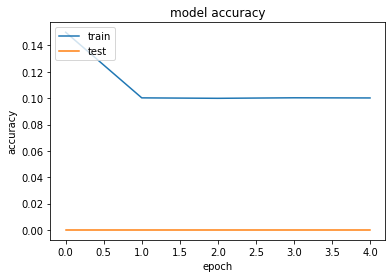

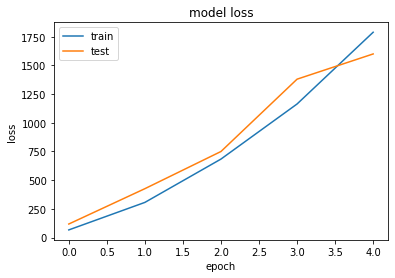

In [24]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()